<a href="https://colab.research.google.com/github/siva-sankar-a/erav1/blob/main/session_11_resnet_gradcam/Session_11_CIFAR10_Gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERA V1 Session 11
## Refer [link](https://github.com/siva-sankar-a/erav1/tree/session/session-6-multiple-architecture-check/session_6_multiple_architectures_mnist#readme) for further documentation

## Cloning the Github repository
## [Session 11](https://github.com/siva-sankar-a/erav1.git)

In [1]:
import numpy as np

In [4]:
!pip install torchviz
!pip install torch-lr-finder
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=47bf8b8db899f05fe76450e5475a07e70b3971b6cb6cf784817f414b0905e0c2
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [5]:
!git clone https://github.com/Fangyh09/pytorch-receptive-field.git
!git clone https://github.com/siva-sankar-a/erav1.git

Cloning into 'erav1'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 347 (delta 115), reused 160 (delta 95), pack-reused 140
Receiving objects: 100% (347/347), 1.55 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [6]:
%cd /content/erav1

/content/erav1


In [258]:
!git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 5), reused 3 (delta 3), pack-reused 0
Unpacking objects: 100% (7/7), 2.43 KiB | 1.21 MiB/s, done.
From https://github.com/siva-sankar-a/erav1
   df9098f..a1d629b  main       -> origin/main
   dea3f4e..ffe28da  sandbox    -> origin/sandbox
   637d993..d7da58e  session/session-11-resnet-gradcam -> origin/session/session-11-resnet-gradcam
Updating df9098f..a1d629b
Fast-forward
 session_11_resnet_gradcam/utils.py | 52 +++++++++++++++++++++++++++++++++++++-
 1 file changed, 51 insertions(+), 1 deletion(-)


## Adding the session folder to path in order to access the functions defined

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
import sys

In [29]:
sys.path.append('/content/erav1/session_11_resnet_gradcam/')
sys.path.append('/content/erav1/pytorch-receptive-field')

In [11]:
import importlib

In [12]:
import utils as U
import datasets as ds
import transforms as tf

In [259]:
U = importlib.reload(U)
ds = importlib.reload(ds)
tf = importlib.reload(tf)

## Get device

In [13]:
device = U.get_device()
print(device)

CUDA Available? True
cuda


In [14]:
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [15]:
pd.options.plotting.backend = "plotly"

## Get train and test transforms

In [16]:
train_transforms = tf.get_CIFAR10_train_transforms()
test_transforms = tf.get_CIFAR10_test_transforms()

In [17]:
from torchvision import datasets, transforms
import numpy as np

In [18]:
from torch.utils.data import WeightedRandomSampler

## Get dataset

In [249]:
train_dataset = ds.get_CIFAR10_albumentations_train_dataset(train_transforms)
test_dataset = ds.get_CIFAR10_albumentations_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Get train and test dataloader

In [21]:
import torch

In [22]:
labels = {0: 'airplane',
          1: 'automobile',
          2: 'bird',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'frog',
          7: 'horse',
          8: 'ship',
          9: 'truck'}

In [23]:
label_weights = { 0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}

In [24]:
_weights = [label_weights[label] for label in train_dataset.targets]

In [25]:
batch_size = 512
sampler = torch.utils.data.sampler.WeightedRandomSampler(_weights, len(train_dataset), replacement=False)

In [26]:
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

train_dataloader = ds.get_train_dataloader(train_dataset, sampler=sampler, **kwargs)
test_dataloader = ds.get_test_dataloader(test_dataset, **kwargs)

## Display image grid

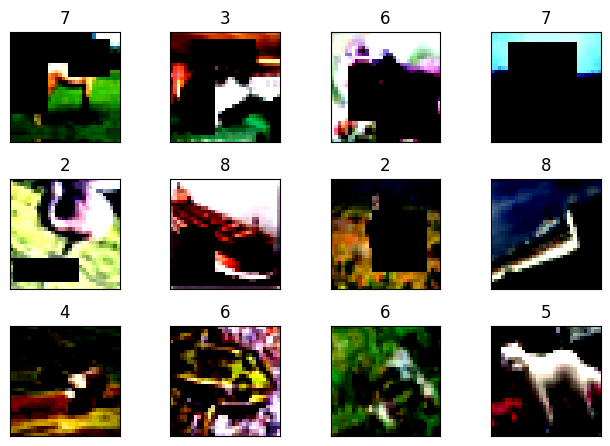

In [27]:
U.show_image_grid(train_dataloader)

In [30]:
from torch_receptive_field import receptive_field

In [31]:
import torch.nn as nn
from torchviz import make_dot
import torch.nn.functional as F

In [33]:
from model.resnet import ResNet18

C1C2C3C40

In [34]:
model = ResNet18()

## LR range finder

In [43]:
from torch_lr_finder import LRFinder
import torch.optim as optim

In [45]:
model = ResNet18().to('cuda')

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.70E-01


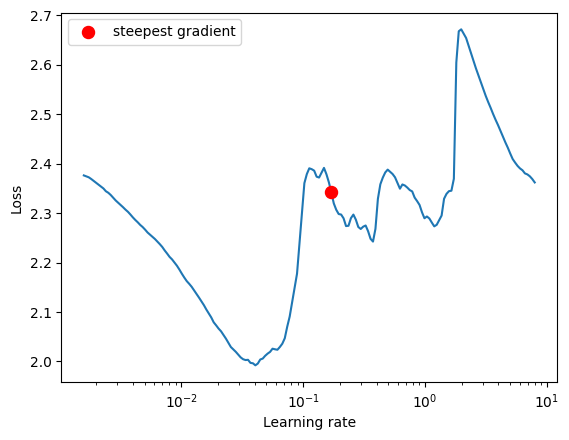

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## Generate model summary

In [47]:
from torchsummary import summary

In [70]:
model = ResNet18().to('cpu')
summary(model, input_size=(3, 32, 32), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 64, 32, 32]           1,728
       BatchNorm2d-2          [512, 64, 32, 32]             128
            Conv2d-3          [512, 64, 32, 32]          36,864
       BatchNorm2d-4          [512, 64, 32, 32]             128
            Conv2d-5          [512, 64, 32, 32]          36,864
       BatchNorm2d-6          [512, 64, 32, 32]             128
        BasicBlock-7          [512, 64, 32, 32]               0
            Conv2d-8          [512, 64, 32, 32]          36,864
       BatchNorm2d-9          [512, 64, 32, 32]             128
           Conv2d-10          [512, 64, 32, 32]          36,864
      BatchNorm2d-11          [512, 64, 32, 32]             128
       BasicBlock-12          [512, 64, 32, 32]               0
           Conv2d-13         [512, 128, 16, 16]          73,728
      BatchNorm2d-14         [512, 128,

## Training

In [71]:
model = ResNet18().to(device)

In [72]:
import torch.optim as optim

In [74]:
num_epochs = 20
momentum = 0.9
max_lr = 1.70E-01
regularization = None
epochs_up = 7
base_momentum = 0.85
div_factor = 100

steps_per_epoch = len(train_dataloader)
total_steps = num_epochs * steps_per_epoch
pct_start = epochs_up / num_epochs

In [75]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=max_lr,
                                          total_steps=total_steps,
                                          epochs=num_epochs,
                                          steps_per_epoch=steps_per_epoch,
                                          pct_start=pct_start,
                                          anneal_strategy='linear',
                                          cycle_momentum=True,
                                          base_momentum=base_momentum,
                                          max_momentum=momentum,
                                          div_factor=div_factor,
                                          verbose=False)

In [76]:
metrics = { 'train_acc': [], 'train_losses': [],
            'test_acc': [], 'test_losses': [] }

for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}')
    U.train(model, device, train_dataloader, optimizer, metrics, scheduler)
    U.test(model, device, test_dataloader, metrics, None, get_misclassified=(epoch == num_epochs))
    # break
    # scheduler.step()

Epoch 1


Train: Loss=1.4316 Batch_id=97 Accuracy=35.71: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]


              precision    recall  f1-score   support

           0       0.56      0.57      0.57      1000
           1       0.71      0.62      0.66      1000
           2       0.45      0.32      0.38      1000
           3       0.36      0.17      0.23      1000
           4       0.50      0.35      0.41      1000
           5       0.40      0.45      0.43      1000
           6       0.83      0.37      0.51      1000
           7       0.31      0.88      0.46      1000
           8       0.68      0.56      0.62      1000
           9       0.57      0.59      0.58      1000

    accuracy                           0.49     10000
   macro avg       0.54      0.49      0.48     10000
weighted avg       0.54      0.49      0.48     10000

Test set: Average loss: 1.4244, Accuracy: 4874/10000 (48.74%)

Epoch 2


Train: Loss=1.1350 Batch_id=97 Accuracy=51.87: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


              precision    recall  f1-score   support

           0       0.75      0.47      0.57      1000
           1       0.51      0.93      0.66      1000
           2       0.76      0.10      0.18      1000
           3       0.80      0.01      0.02      1000
           4       0.52      0.31      0.39      1000
           5       0.63      0.17      0.27      1000
           6       0.52      0.82      0.64      1000
           7       0.29      0.93      0.45      1000
           8       0.66      0.74      0.70      1000
           9       0.71      0.47      0.57      1000

    accuracy                           0.50     10000
   macro avg       0.62      0.50      0.44     10000
weighted avg       0.62      0.50      0.44     10000

Test set: Average loss: 1.8182, Accuracy: 4952/10000 (49.52%)

Epoch 3


Train: Loss=1.1916 Batch_id=97 Accuracy=60.91: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1000
           1       0.59      0.94      0.73      1000
           2       0.39      0.74      0.51      1000
           3       0.62      0.19      0.30      1000
           4       0.83      0.19      0.31      1000
           5       0.75      0.33      0.46      1000
           6       0.91      0.36      0.52      1000
           7       0.62      0.56      0.59      1000
           8       0.80      0.74      0.77      1000
           9       0.34      0.83      0.48      1000

    accuracy                           0.55     10000
   macro avg       0.66      0.55      0.53     10000
weighted avg       0.66      0.55      0.53     10000

Test set: Average loss: 1.6301, Accuracy: 5524/10000 (55.24%)

Epoch 4


Train: Loss=0.9523 Batch_id=97 Accuracy=66.11: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1000
           1       0.91      0.82      0.86      1000
           2       0.68      0.53      0.60      1000
           3       0.40      0.70      0.51      1000
           4       0.58      0.81      0.68      1000
           5       0.54      0.68      0.60      1000
           6       0.77      0.76      0.77      1000
           7       0.98      0.40      0.57      1000
           8       0.86      0.72      0.78      1000
           9       0.86      0.83      0.84      1000

    accuracy                           0.69     10000
   macro avg       0.75      0.69      0.69     10000
weighted avg       0.75      0.69      0.69     10000

Test set: Average loss: 0.9797, Accuracy: 6859/10000 (68.59%)

Epoch 5


Train: Loss=0.8689 Batch_id=97 Accuracy=70.20: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1000
           1       0.86      0.92      0.89      1000
           2       0.74      0.59      0.66      1000
           3       0.42      0.79      0.55      1000
           4       0.70      0.80      0.74      1000
           5       0.87      0.35      0.50      1000
           6       0.93      0.63      0.75      1000
           7       0.88      0.76      0.82      1000
           8       0.75      0.94      0.83      1000
           9       0.80      0.84      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.78      0.73      0.73     10000
weighted avg       0.78      0.73      0.73     10000

Test set: Average loss: 0.7731, Accuracy: 7326/10000 (73.26%)

Epoch 6


Train: Loss=0.6834 Batch_id=97 Accuracy=72.98: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.65      0.86      0.75      1000
           1       0.84      0.93      0.88      1000
           2       0.82      0.55      0.66      1000
           3       0.74      0.46      0.57      1000
           4       0.56      0.77      0.64      1000
           5       0.76      0.58      0.66      1000
           6       0.61      0.92      0.74      1000
           7       0.97      0.48      0.64      1000
           8       0.71      0.92      0.80      1000
           9       0.90      0.73      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.76      0.72      0.71     10000
weighted avg       0.76      0.72      0.71     10000

Test set: Average loss: 0.9507, Accuracy: 7219/10000 (72.19%)

Epoch 7


Train: Loss=0.7085 Batch_id=97 Accuracy=74.67: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.90      0.52      0.66      1000
           1       0.83      0.94      0.88      1000
           2       0.95      0.38      0.54      1000
           3       0.48      0.82      0.61      1000
           4       0.59      0.89      0.71      1000
           5       0.74      0.66      0.70      1000
           6       0.94      0.69      0.80      1000
           7       0.93      0.76      0.83      1000
           8       0.85      0.91      0.88      1000
           9       0.78      0.91      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.80      0.75      0.74     10000
weighted avg       0.80      0.75      0.74     10000

Test set: Average loss: 0.8414, Accuracy: 7479/10000 (74.79%)

Epoch 8


Train: Loss=0.6265 Batch_id=97 Accuracy=77.14: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1000
           1       0.96      0.87      0.91      1000
           2       0.82      0.68      0.74      1000
           3       0.58      0.76      0.66      1000
           4       0.84      0.73      0.78      1000
           5       0.75      0.70      0.73      1000
           6       0.70      0.94      0.80      1000
           7       0.90      0.84      0.87      1000
           8       0.84      0.92      0.88      1000
           9       0.87      0.92      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

Test set: Average loss: 0.5715, Accuracy: 8051/10000 (80.51%)

Epoch 9


Train: Loss=0.6717 Batch_id=97 Accuracy=79.34: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1000
           1       0.89      0.96      0.93      1000
           2       0.64      0.87      0.74      1000
           3       0.83      0.48      0.61      1000
           4       0.84      0.81      0.82      1000
           5       0.62      0.85      0.72      1000
           6       0.96      0.69      0.81      1000
           7       0.89      0.87      0.88      1000
           8       0.95      0.87      0.91      1000
           9       0.91      0.89      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.82      0.82     10000

Test set: Average loss: 0.5513, Accuracy: 8187/10000 (81.87%)

Epoch 10


Train: Loss=0.5969 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1000
           1       0.81      0.98      0.89      1000
           2       0.44      0.94      0.60      1000
           3       0.67      0.73      0.70      1000
           4       0.69      0.81      0.74      1000
           5       0.88      0.56      0.68      1000
           6       0.97      0.67      0.79      1000
           7       0.98      0.61      0.76      1000
           8       0.99      0.76      0.86      1000
           9       0.94      0.84      0.89      1000

    accuracy                           0.76     10000
   macro avg       0.83      0.76      0.77     10000
weighted avg       0.83      0.76      0.77     10000

Test set: Average loss: 0.7357, Accuracy: 7627/10000 (76.27%)

Epoch 11


Train: Loss=0.3959 Batch_id=97 Accuracy=82.46: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.87      0.97      0.92      1000
           2       0.93      0.63      0.75      1000
           3       0.79      0.65      0.71      1000
           4       0.80      0.87      0.83      1000
           5       0.82      0.77      0.79      1000
           6       0.70      0.97      0.81      1000
           7       0.89      0.90      0.90      1000
           8       0.94      0.90      0.92      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Test set: Average loss: 0.4854, Accuracy: 8425/10000 (84.25%)

Epoch 12


Train: Loss=0.4329 Batch_id=97 Accuracy=83.83: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       0.81      0.98      0.89      1000
           2       0.73      0.88      0.80      1000
           3       0.76      0.67      0.71      1000
           4       0.86      0.79      0.82      1000
           5       0.89      0.68      0.77      1000
           6       0.71      0.95      0.82      1000
           7       0.95      0.84      0.89      1000
           8       0.89      0.96      0.92      1000
           9       0.99      0.73      0.84      1000

    accuracy                           0.83     10000
   macro avg       0.85      0.83      0.83     10000
weighted avg       0.85      0.83      0.83     10000

Test set: Average loss: 0.5240, Accuracy: 8350/10000 (83.50%)

Epoch 13


Train: Loss=0.4218 Batch_id=97 Accuracy=84.91: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1000
           1       0.95      0.93      0.94      1000
           2       0.90      0.78      0.83      1000
           3       0.73      0.76      0.74      1000
           4       0.83      0.90      0.87      1000
           5       0.77      0.85      0.81      1000
           6       0.94      0.86      0.90      1000
           7       0.92      0.88      0.90      1000
           8       0.94      0.94      0.94      1000
           9       0.89      0.96      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000

Test set: Average loss: 0.3818, Accuracy: 8737/10000 (87.37%)

Epoch 14


Train: Loss=0.3283 Batch_id=97 Accuracy=85.90: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1000
           1       0.90      0.98      0.94      1000
           2       0.94      0.71      0.81      1000
           3       0.74      0.78      0.76      1000
           4       0.91      0.84      0.88      1000
           5       0.79      0.85      0.82      1000
           6       0.89      0.93      0.91      1000
           7       0.91      0.92      0.91      1000
           8       0.97      0.91      0.94      1000
           9       0.94      0.91      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test set: Average loss: 0.3786, Accuracy: 8792/10000 (87.92%)

Epoch 15


Train: Loss=0.3209 Batch_id=97 Accuracy=87.09: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1000
           1       0.90      0.98      0.94      1000
           2       0.84      0.82      0.83      1000
           3       0.86      0.65      0.74      1000
           4       0.88      0.87      0.88      1000
           5       0.90      0.72      0.80      1000
           6       0.88      0.94      0.91      1000
           7       0.81      0.95      0.88      1000
           8       0.96      0.89      0.92      1000
           9       0.89      0.92      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Test set: Average loss: 0.4196, Accuracy: 8677/10000 (86.77%)

Epoch 16


Train: Loss=0.3979 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1000
           1       0.97      0.94      0.95      1000
           2       0.82      0.89      0.85      1000
           3       0.91      0.57      0.70      1000
           4       0.88      0.89      0.89      1000
           5       0.72      0.91      0.80      1000
           6       0.93      0.91      0.92      1000
           7       0.91      0.94      0.93      1000
           8       0.91      0.96      0.93      1000
           9       0.91      0.96      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Test set: Average loss: 0.3582, Accuracy: 8828/10000 (88.28%)

Epoch 17


Train: Loss=0.3277 Batch_id=97 Accuracy=88.89: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1000
           1       0.97      0.94      0.95      1000
           2       0.81      0.90      0.85      1000
           3       0.86      0.71      0.78      1000
           4       0.92      0.87      0.89      1000
           5       0.77      0.90      0.83      1000
           6       0.93      0.93      0.93      1000
           7       0.93      0.92      0.93      1000
           8       0.96      0.92      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Test set: Average loss: 0.3201, Accuracy: 8955/10000 (89.55%)

Epoch 18


Train: Loss=0.2964 Batch_id=97 Accuracy=89.90: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1000
           1       0.96      0.96      0.96      1000
           2       0.89      0.84      0.87      1000
           3       0.85      0.69      0.76      1000
           4       0.94      0.84      0.89      1000
           5       0.74      0.92      0.82      1000
           6       0.93      0.94      0.93      1000
           7       0.90      0.96      0.93      1000
           8       0.95      0.95      0.95      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Test set: Average loss: 0.3196, Accuracy: 8956/10000 (89.56%)

Epoch 19


Train: Loss=0.2188 Batch_id=97 Accuracy=90.61: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1000
           1       0.96      0.96      0.96      1000
           2       0.87      0.88      0.88      1000
           3       0.84      0.80      0.82      1000
           4       0.89      0.92      0.91      1000
           5       0.87      0.85      0.86      1000
           6       0.92      0.95      0.93      1000
           7       0.94      0.93      0.94      1000
           8       0.96      0.94      0.95      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Test set: Average loss: 0.2845, Accuracy: 9098/10000 (90.98%)

Epoch 20


Train: Loss=0.2611 Batch_id=97 Accuracy=91.57: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1000
           1       0.96      0.96      0.96      1000
           2       0.90      0.87      0.88      1000
           3       0.83      0.82      0.82      1000
           4       0.91      0.91      0.91      1000
           5       0.86      0.87      0.86      1000
           6       0.94      0.94      0.94      1000
           7       0.95      0.94      0.94      1000
           8       0.95      0.95      0.95      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Test set: Average loss: 0.2750, Accuracy: 9130/10000 (91.30%)



In [79]:
df_misclassified = pd.DataFrame(metrics['misclassified_data'])

In [261]:
df_misclassified.sample(n=10)

,pred,actual,data
825,2,4,"[[[0.1697494, 0.29674718, 0.40787023, 0.487243..."
109,5,7,"[[[1.1539822, 1.1381075, 1.1539822, 1.1381075,..."
505,6,2,"[[[0.15387467, 0.1062505, -0.08424617, -0.1318..."
342,3,5,"[[[-1.7828416, -1.7828416, -1.7828416, -1.7828..."
412,2,4,"[[[0.5983669, 0.80473834, 0.7888636, 0.8682372..."
419,4,3,"[[[-0.48111424, -0.56048787, -0.5763626, -0.51..."
196,5,3,"[[[0.32849663, 0.4554944, 0.63011634, 0.661865..."
150,6,4,"[[[-0.2429934, -0.48111424, -0.5446131, 0.1697..."
132,3,5,"[[[-1.7669668, -0.94148123, -0.68748564, -0.60..."
149,5,3,"[[[-0.71923506, -1.0049801, -0.75098455, -0.71..."


In [262]:
df_misclassified_10 = df_misclassified.sample(n=10)

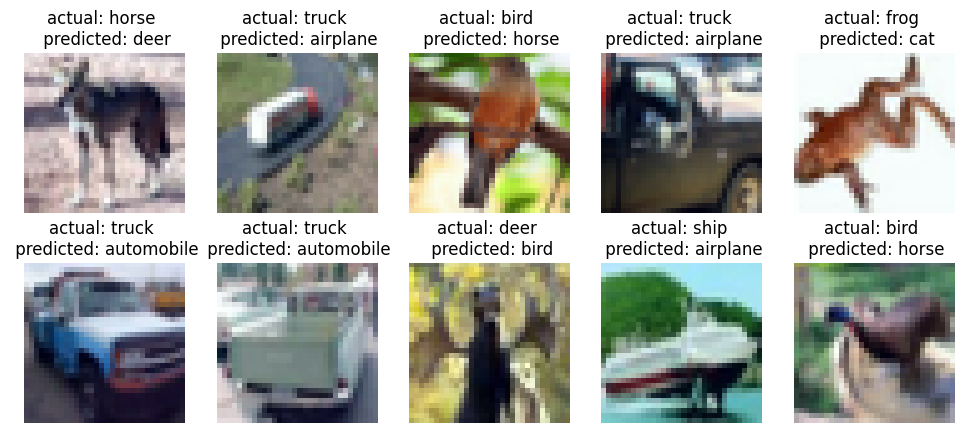

<Figure size 640x480 with 0 Axes>

In [263]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

for i, row in df_misclassified_10.reset_index(drop=True).iterrows():
    ax = plt.subplot(2, 5, i+1)
    plt.axis('off')

    img = row['data']
    img = (img - img.min()) / (img.max() - img.min())
    img = np.moveaxis(img * 255, [0, 1, 2], [2, 0, 1])
    plt.imshow(img.astype(int), cmap='jet')

    ax.set_title(f"actual: {labels[row['actual']]} \n predicted: {labels[row['pred']]}")

plt.show()
plt.savefig('failed.jpg')

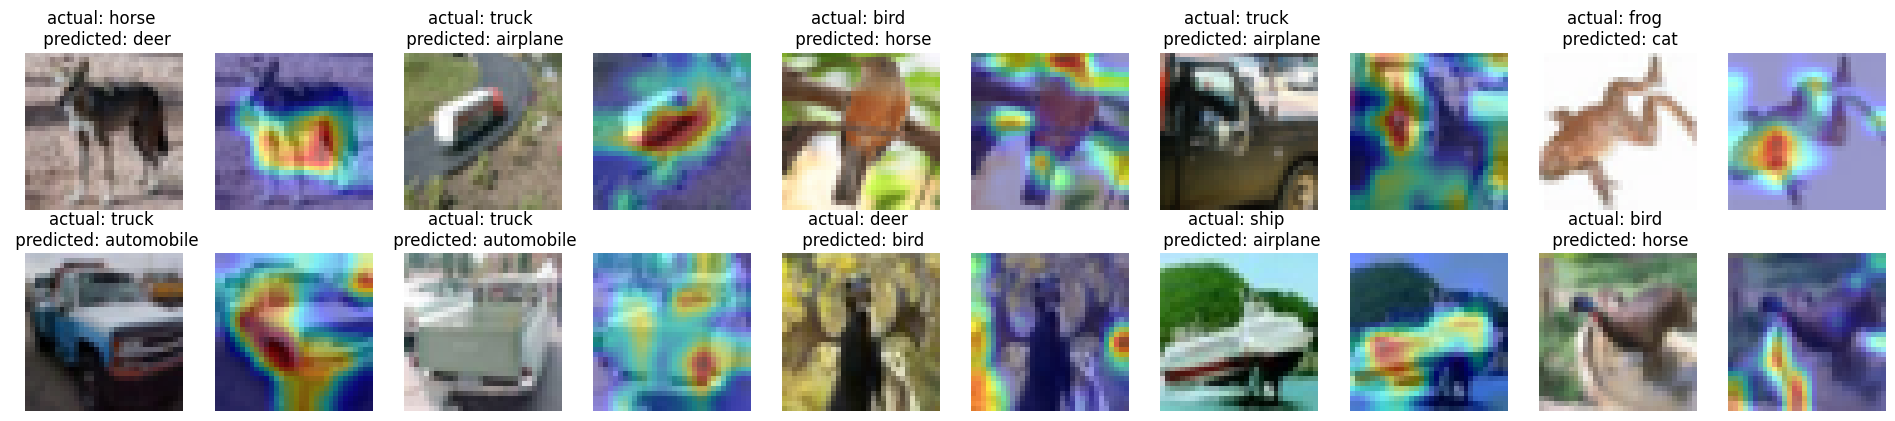

<Figure size 640x480 with 0 Axes>

In [264]:
U.gradcam(df_misclassified_10, model, [model.layer3[-1]], labels)

## Display Results

In [66]:
df = pd.DataFrame({'train_losses': metrics['train_losses'], 'test_losses': metrics['test_losses']})

In [67]:
df.plot()

In [68]:
df = pd.DataFrame({'train_acc': metrics['train_acc'], 'test_acc': metrics['test_acc']})
df.plot()